In [1]:
!pip install git+https://github.com/keras-team/keras-applications.git -q
!pip install kaggle --upgrade

In [65]:
!pip install kaggledatasets

In [2]:
import os

os.environ['KAGGLE_USERNAME'] = 'kikiru328'
os.environ['KAGGLE_KEY'] = 'f6371f6a038388810664abcff5c4c1bf'

In [108]:
# !kaggle datasets download -d nih-chest-xrays/data
# !kaggle datasets download -d akhileshdkapse/nih-dataframe
!kaggle datasets download -d akhileshdkapse/nih-image-600x600-data
# !kaggle datasets download -d ipythonx/keras-pretrained-imagenet-weights
# !unzip '*.zip'

nih-image-600x600-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [14]:
import keras_applications as ka
def set_to_tf(ka):
    from tensorflow.keras import backend, layers, models, utils
    ka._KERAS_BACKEND = backend
    ka._KERAS_LAYERS = layers
    ka._KERAS_MODELS = models
    ka._KERAS_UTILS = utils

In [16]:
set_to_tf(ka)

In [17]:
!pip install /content/image_classifiers-1.0.0-py3-none-any.whl

Processing ./image_classifiers-1.0.0-py3-none-any.whl


In [18]:
from classification_models.tfkeras import Classifiers
Classifiers.models_names()

['resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'seresnet18',
 'seresnet34',
 'seresnet50',
 'seresnet101',
 'seresnet152',
 'seresnext50',
 'seresnext101',
 'senet154',
 'resnet50v2',
 'resnet101v2',
 'resnet152v2',
 'resnext50',
 'resnext101',
 'vgg16',
 'vgg19',
 'densenet121',
 'densenet169',
 'densenet201',
 'inceptionresnetv2',
 'inceptionv3',
 'xception',
 'nasnetlarge',
 'nasnetmobile',
 'mobilenet',
 'mobilenetv2']

In [ ]:
!pip install fsspec
!pip install gcsfs

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# ML tools 
import tensorflow as tf
import kaggledatasets
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import tensorflow.keras.applications.efficientnet as efn
from tensorflow.keras.applications import *
import os
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from tensorflow.keras.metrics import *

In [124]:
df = pd.read_csv('/content/NIH_Dataframe.csv')
df.img_ind= df.img_ind.apply(lambda x: x.split('.')[0])
display(df.head(4))
print(df.shape)

,Cardiomegaly,Hernia,Infiltration,Nodule,Emphysema,Effusion,Atelectasis,Pleural_Thickening,Pneumothorax,Mass,Fibrosis,Consolidation,Edema,Pneumonia,img_ind
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00000001_000
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00000001_001
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00000001_002
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00000003_000


(51759, 15)


In [125]:
target_cols = df.drop(['img_ind'], axis=1).columns.to_list()
n_classes = len(target_cols)
img_size = 600
n_epochs = 35
lr= 0.0001
seed= 11
val_split= 0.2
seed= 33
batch_size=12
n_classes

14

In [126]:
def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy

def build_decoder(with_labels=True, target_size=(img_size, img_size), ext='jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path) # Reads and outputs the entire contents of the input filename.

        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3) # Decode a PNG-encoded image to a uint8 or uint16 tensor
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3) # Decode a JPEG-encoded image to a uint8 tensor
        else:
            raise ValueError("Image extension not supported")

        img = tf.cast(img, tf.float32) / 255.0 # Casts a tensor to the type float32 and divides by 255.
        img = tf.image.resize(img, target_size) # Resizing to target size
        return img
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_saturation(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    
    return augment_with_labels if with_labels else augment

def build_dataset(paths, labels=None, bsize=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO) # overlaps data preprocessing and model execution while training
    return dset

In [127]:
DATASET_NAME = "nih-image-600x600-data"
strategy = auto_select_accelerator()
batch_size = strategy.num_replicas_in_sync * batch_size
print('batch size', batch_size)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.66.165.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.66.165.234:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU: grpc://10.66.165.234:8470
Running on 8 replicas
batch size 96


In [128]:
# GCS_DS_PATH = kaggledatasets.dataset().get_gcs_path(DATASET_NAME)
# # GCS_DS_PATH = 'gs://kds-dea3f7cf676c39d98adac1d05a88986e3b69a0029888f0413d350f98'

In [129]:
paths = '/content/NIH_Images/' + df['img_ind'] + '.jpg'


#Get the multi-labels
label_cols = df.columns[:-1]
labels = df[label_cols].values

In [130]:
# Train test split
(train_paths, valid_paths, 
  train_labels, valid_labels) = train_test_split(paths, labels, test_size=val_split, random_state=11)

print(train_paths.shape, valid_paths.shape)
train_labels.sum(axis=0), valid_labels.sum(axis=0)

(41407,) (10352,)


(array([ 2204.,   179., 15858.,  5070.,  2006., 10651.,  9317.,  2705.,
         4210.,  4634.,  1351.,  3779.,  1836.,  1159.]),
 array([ 572.,   48., 4036., 1261.,  510., 2666., 2242.,  680., 1092.,
        1148.,  335.,  888.,  467.,  272.]))

In [131]:
# Build the tensorflow datasets

decoder = build_decoder(with_labels=True, target_size=(img_size, img_size))

# Build the tensorflow datasets
dtrain = build_dataset(
    train_paths, train_labels, bsize=batch_size, decode_fn=decoder
)

dvalid = build_dataset(
    valid_paths, valid_labels, bsize=batch_size, 
    repeat=False, shuffle=False, augment=False, decode_fn=decoder
)

In [132]:
def build_model():
    seresnet152, _ = Classifiers.get('seresnet152')
    base = seresnet152(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
    
    inp = layers.Input(shape = (img_size, img_size, 3))
    x= base(inp)
    x= layers.GlobalAveragePooling2D()(layers.Dropout(0.16)(x))
    x= layers.Dropout(0.3)(x)
    x= layers.Dense(n_classes, 'sigmoid')(x)
    return Model(inp, x)

In [133]:
with strategy.scope():
    model= build_model()
    loss= tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0)
    model.compile(Adam(lr=lr),loss=loss,metrics=[AUC(multi_label=True)])

In [134]:
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 600, 600, 3)]     0         
                                                                 
 model_12 (Functional)       (None, 19, 19, 2048)      64924272  
                                                                 
 dropout_12 (Dropout)        (None, 19, 19, 2048)      0         
                                                                 
 global_average_pooling2d_35  (None, 2048)             0         
 6 (GlobalAveragePooling2D)                                      
                                                                 
 dropout_13 (Dropout)        (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 14)                28686     
                                                          

In [135]:
name= 'NIH_Seresnet152_model.h5'

rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, verbose = 1, 
                                min_delta = 1e-4, min_lr = 1e-6, mode = 'min', cooldown=1)
        
ckp = ModelCheckpoint(name,monitor = 'val_loss',
                      verbose = 1, save_best_only = True, mode = 'min')
        
es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 5, mode = 'min', 
                    restore_best_weights = True, verbose = 1)

In [136]:
steps_per_epoch = (train_paths.shape[0] // batch_size)
steps_per_epoch

431

In [ ]:
checkpoint = tf.train.Checkpoint(model=model)
local_device_option = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")
checkpoint.write(checkpoint_path, options=local_device_option)

In [137]:
history = model.fit(dtrain,                      
                    validation_data=dvalid,                                       
                    epochs=n_epochs,
                    callbacks=[rlr,es,ckp],
                    steps_per_epoch=steps_per_epoch,
                    verbose=1)

Epoch 1/35


UnimplementedError: ignored

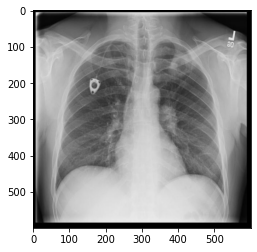

In [122]:
import cv2
plt.imshow(plt.imread('/content/NIH_Images/00023073_000.jpg'))

In [ ]:
plt.figure(figsize = (12, 6))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( history.history["loss"], label = "Training Loss", marker='o')
plt.plot( history.history["val_loss"], label = "Validation Loss", marker='+')
plt.grid(True)
plt.legend()
plt.show()